In [40]:
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 10})
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = True

# plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2

def load_price_data(path_to_data_dir="../data/",price_file="eth_usd_price"):
    with open(path_to_data_dir+price_file+".csv","r") as infile:
        try:
            df = pd.read_csv(infile)
            print(df.shape)
        except Exception as e:
            print(e)

    df['datetime'] = pd.to_datetime(df['unix_timestamp'], unit='s')    
    df.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    df['date'] = df['datetime'].dt.date
    return(df)

def process_daily_summary(price_data):
    price_data["weighted_avg"] = price_data["volume"]*price_data["close"]    
    price_data['volatility'] = price_data['close'].pct_change()
    
    daily_price_data = price_data.groupby("date").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "unix_timestamp": "first",
        "weighted_avg": "sum",
        "volatility": "sum",
        })
    
    daily_price_data["weighted_avg"] = daily_price_data["weighted_avg"]/daily_price_data["volume"]
    return(daily_price_data)

def price_analysis(daily_price_data,price_file = "usdt_usdc_price",
                   jump_threshold=.04,recovery_mean=None,recovery_threshold=0.005,
                   trunc_window_start=None,trunc_window_end=None):        
    #### Compute GBM Mu and Sigma
    daily_price_data['daily_return'] = daily_price_data['weighted_avg'].pct_change()
    daily_price_data['log_daily_return'] = np.log(daily_price_data['weighted_avg'] / daily_price_data['weighted_avg'].shift(1))

    # Drop NaN values (the first entry will be NaN due to the shift)
    daily_price_data = daily_price_data.dropna()

    # Calculate mean (mu) and standard deviation (sigma) of daily returns
    mu = daily_price_data['log_daily_return'].mean()
    sigma = daily_price_data['log_daily_return'].std()

    print("Mean (mu) of daily returns:", mu)
    print("Standard deviation (sigma) of daily returns:", sigma)

    # plt.figure()
    # plt.plot(daily_price_data["weighted_avg"])

    #### Jump Diffusion - Magnitude Analysis
    daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]
    counts,bin_edges = np.histogram(daily_price_data["drops"],bins=100)
    hist_daily_df = pd.DataFrame({"Bin_Left_Edge":bin_edges[:-1],"Bin_Reft_Edge":bin_edges[1:],"Count":counts})
    # plt.figure()
    # plt.hist(daily_price_data["drops"],bins=100,log=True)
    # plt.title('Main Title')
    # plt.xlabel('Drop Size (%)')
    # plt.ylabel('# Days')
    # plt.show()

    #### Jump Diffusion - Recovery Analysis     
    recovery_times = []
    jump_state = False
    jump_timer=0    

    daily_price_data["jump_state"]=False
    daily_price_data["recovery_mean"]=recovery_mean    
    daily_price_data["ema"]=daily_price_data["weighted_avg"].ewm(span=9, adjust=False).mean()

    for index, row in daily_price_data.iterrows():    
        jump_clear = abs(row["daily_return"])>=jump_threshold
        
        if recovery_mean==None:            
            daily_price_data.loc[index,"recovery_mean"] = daily_price_data.loc[index,"ema"]
        in_recovery_range = abs(daily_price_data.loc[index,"recovery_mean"]-row["weighted_avg"])<daily_price_data.loc[index,"recovery_mean"]*recovery_threshold
        
        if jump_state==True:
            jump_timer+=1
            if in_recovery_range:
                recovery_times+=[jump_timer]
                jump_state=False
                jump_timer=0    
            else:
                pass
        else: 
            if jump_clear:
                jump_state=True
            else:
                pass    
        daily_price_data.loc[index, "jump_state"] = jump_state

    # plt.figure()
    # plt.plot(daily_price_data["daily_return"])
    # plt.axhline(y=jump_threshold, color='r', linestyle='--')
    # plt.axhline(y=-1*jump_threshold, color='r', linestyle='--')

    daily_price_data.index = pd.to_datetime(daily_price_data.index)
    
    if trunc_window_start!=None and trunc_window_end!=None:
        trunc_daily_price_data = daily_price_data[(daily_price_data.index>=trunc_window_start) & (daily_price_data.index<=trunc_window_end)]
    else:
        trunc_daily_price_data = daily_price_data

    return trunc_daily_price_data

def plot_jumps(df, recovery_threshold, fn=None):
    f, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(df["weighted_avg"], color = 'royalblue', lw=1, label='WAVG Price')
    ax.plot(df["recovery_mean"]*(1+recovery_threshold), color='black', linestyle='--', lw=1, label='Recovery Threshold')
    ax.plot(df["recovery_mean"]*(1-recovery_threshold), color='black', linestyle='--', lw=1)
    ax.set_ylabel('ETH Price (USD)')
    ax.set_title('Detecting ETH Jumps')

    for i, row in df.iterrows():
        left_edge = i - pd.to_timedelta(.5, unit='D')
        right_edge = i + pd.to_timedelta(.5, unit='D')
        if row['jump_state'] == True: 
            ax.axvspan(left_edge, right_edge, color="indianred")

    ax.axvspan(None, None, color='indianred', label='Jump')
    ax.tick_params(axis='x', rotation=45)
    
    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
    f.tight_layout()

    if fn:
        f.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f

In [41]:
#### ETH Price Analysis
price_file="eth_usd_price"
price_data = load_price_data(path_to_data_dir="../data/",price_file=price_file)
daily_price_data = process_daily_summary(price_data)
df = price_analysis(daily_price_data,price_file=price_file,
               jump_threshold = .1,recovery_mean = None,recovery_threshold = 0.05,
               trunc_window_start=None,
               trunc_window_end=None)

(16048, 8)
Mean (mu) of daily returns: -0.0010887960696717581
Standard deviation (sigma) of daily returns: 0.03125021914966718


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_94525/3446294840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_94525/3446294840.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["jump_state"]=False
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_94525/3446294840.py:87: SettingWithCopyWarning: 

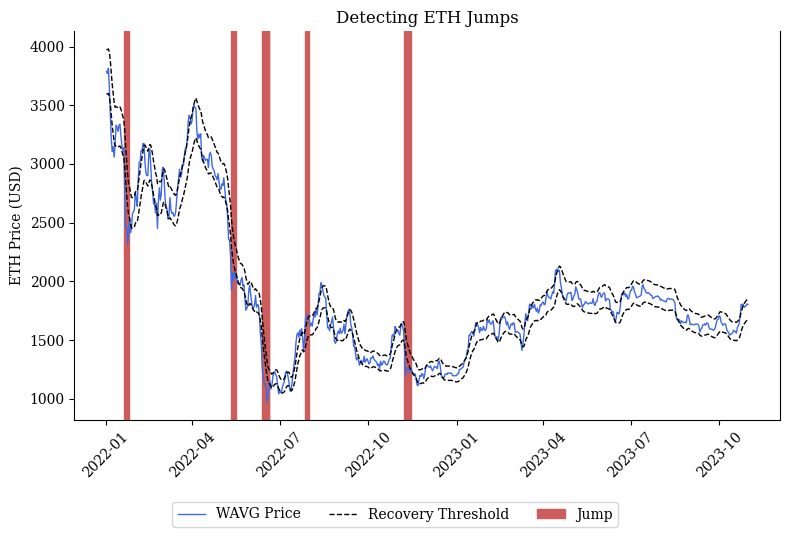

In [42]:
plot_jumps(df, 0.05, '../figs/manual/eth_jumps.png')

(14656, 8)
Mean (mu) of daily returns: 2.1037989538991367e-07
Standard deviation (sigma) of daily returns: 0.003190873414000883


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_9745/648492013.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]


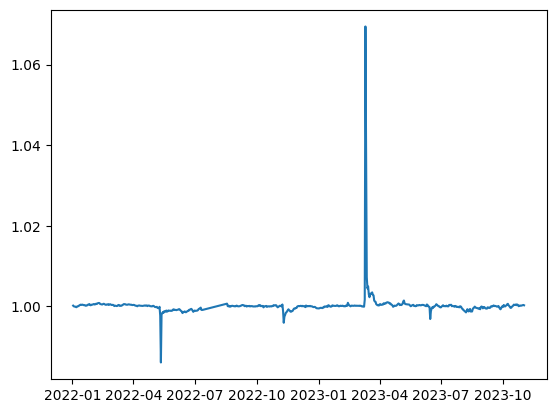

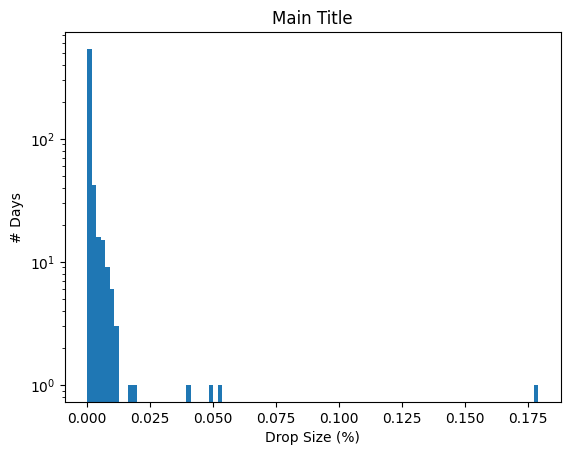

/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_9745/648492013.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["jump_state"]=False
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_9745/648492013.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["recovery_mean"]=recovery_mean
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_9745/648492013.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


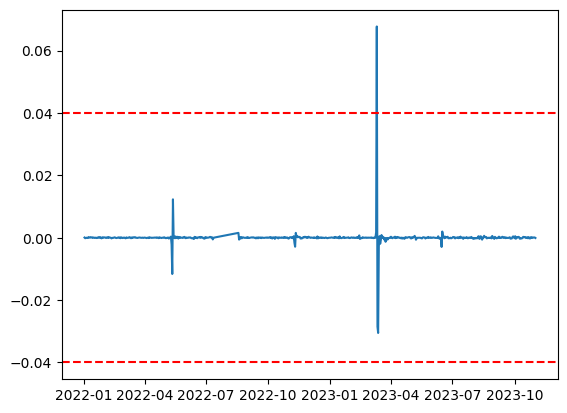

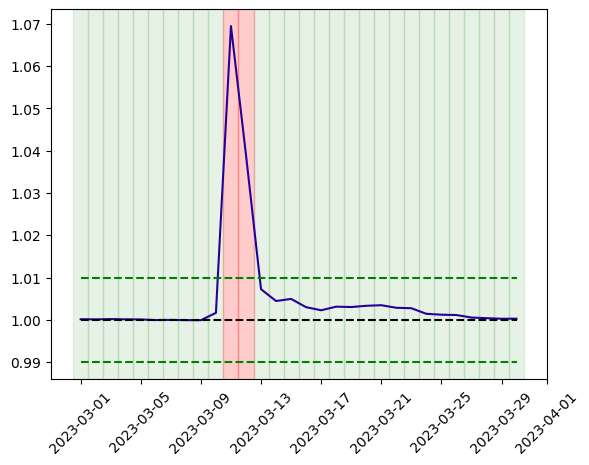

In [3]:
#### Stablecoin Price Analysis
price_file="usdt_usdc_price"
price_data = load_price_data(path_to_data_dir="../data/",price_file=price_file)
daily_price_data = process_daily_summary(price_data)
price_analysis(daily_price_data,price_file=price_file,
               jump_threshold = .04,recovery_mean = 1,recovery_threshold = 0.01,
               trunc_window_start=datetime.datetime(2023, 3, 1),
               trunc_window_end=datetime.datetime(2023, 3, 30))